In [1]:
# pip install -r requirements.txt or:

# %pip install "rembg[GPU]"
# %pip install carvekit --extra-index-url https://download.pytorch.org/whl/cu113
# %pip install matplotlib pandas transformers

# Imports

In [2]:
import glob
import os
import time
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import pandas as pd
import torch
from carvekit.api.high import HiInterface
from PIL import Image
from rembg import remove
from rembg.session_factory import new_session
from tqdm import tqdm
from transformers import BlipForConditionalGeneration, BlipProcessor

print(ort.get_available_providers())

/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


if you have GPU
and 'CUDAExecutionProvider' not in  ort.get_available_providers() do 
```
pip uninstall onnxruntime-gpu
pip install onnxruntime-gpu
```
then restart the kernel and run all

# background adding

In [3]:
def create_gradient_background(
    size: tuple,
    color: str = "gray",
    start_intensity: int = 50,
    end_intensity: int = 200,
    orientation: str = "vertical",
) -> np.ndarray:
    """
    Создает градиентный фон с возможностью выбора цвета.

    Параметры:
    size (tuple): Размер фона (высота, ширина).
    color (str): Цвет градиента ('gray', 'red', 'green', 'blue').
    start_intensity (int): Начальная интенсивность градиента.
    end_intensity (int): Конечная интенсивность градиента.
    orientation (str): Ориентация градиента ('vertical' или 'horizontal').

    Возвращает:
    np.ndarray: Изображение с градиентным фоном.
    """
    height, width = size
    gradient = np.zeros((height, width, 3), dtype=np.uint8)

    if orientation == "vertical":
        for i in range(height):
            ratio = i / height
            intensity = int(start_intensity * (1 - ratio) + end_intensity * ratio)

            if color == "gray":
                gradient[i, :, :] = (intensity, intensity, intensity)
            elif color == "red":
                gradient[i, :, :] = (intensity, 0, 0)
            elif color == "green":
                gradient[i, :, :] = (0, intensity, 0)
            elif color == "blue":
                gradient[i, :, :] = (0, 0, intensity)
    elif orientation == "horizontal":
        for i in range(width):
            ratio = i / width
            intensity = int(start_intensity * (1 - ratio) + end_intensity * ratio)

            if color == "gray":
                gradient[:, i, :] = (intensity, intensity, intensity)
            elif color == "red":
                gradient[:, i, :] = (intensity, 0, 0)
            elif color == "green":
                gradient[:, i, :] = (0, intensity, 0)
            elif color == "blue":
                gradient[:, i, :] = (0, 0, intensity)

    return gradient


def apply_background(
    image: np.ndarray, mask: np.ndarray, background: np.ndarray
) -> np.ndarray:
    """
    Накладывает изображение на градиентный фон.

    Параметры:
    image (np.ndarray): Изображение без фона.
    mask (np.ndarray): Бинарная маска изображения (0 или 1).
    background (np.ndarray): Градиентный фон.

    Возвращает:
    np.ndarray: Изображение с новым фоном.
    """
    if image.shape[:2] != background.shape[:2]:
        raise ValueError("Размеры изображения и фона не совпадают")

    final_image = image * mask + background * (1 - mask)

    return final_image


In [4]:
def display_images_in_row(
    image_list: list[np.ndarray], title: str | None = None
) -> None:
    """
    Функция для отображения списка изображений в одной строке.

    Параметры:
    image_list (list): Список изображений в формате NumPy массивов.
    """
    num_images = len(image_list)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    if num_images == 1:
        axes = [axes]

    for ax, img in zip(axes, image_list):
        ax.imshow(img, cmap="gray")
        ax.axis("off")

    if title:
        fig.suptitle(title)

    plt.show()


def pixel_distribution(image: np.ndarray) -> dict[int:int]:
    """
    Возвращает распределение значений пикселей

    Параметры:
    image (np.ndarray): Изображение без фона.

    Возвращает:
    dict: Ключ - значение пикселя от 0 до 255, значение - кол-во таких пикселей.
    """
    pixel_array = np.array(image)
    pixel_counts = Counter(pixel_array.flatten())
    pixel_distribution_dict = {
        i: count for i, count in pixel_counts.items() if count > 0
    }

    return pixel_distribution_dict

# data analys

In [5]:
data_directory = "./sirius_data"
image_paths = glob.glob(f"{data_directory}/*.jpg")
len(image_paths)

470

In [6]:
widths = []
heights = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    heights.append(image.shape[0])
    widths.append(image.shape[1])

print(min(heights), max(heights), sum(heights) / len(heights), len(heights))
print(min(widths), max(widths), sum(widths) / len(widths), len(widths))

328 328 328.0 470
246 246 246.0 470


# Trace-B7 vs $U^2$-Net

In [7]:
interface_tracer = HiInterface(
    object_type="object",  # Can be "object" or "hairs-like".
    batch_size_seg=5,
    batch_size_matting=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seg_mask_size=480,  # Use 640 for Tracer B7 and 320 for U2Net
    matting_mask_size=2048,
    trimap_prob_threshold=231,
    trimap_dilation=30,
    trimap_erosion_iters=5,
    fp16=False,
)

interface_u2net = HiInterface(
    object_type="hairs-like",  # Can be "object" or "hairs-like".
    batch_size_seg=5,
    batch_size_matting=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
    seg_mask_size=320,  # Use 640 for Tracer B7 and 320 for U2Net
    matting_mask_size=2048,
    trimap_prob_threshold=231,
    trimap_dilation=30,
    trimap_erosion_iters=5,
    fp16=False,
)
interfaces = [interface_tracer, interface_u2net]

/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/carvekit/ml/wrap/tracer_b7.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path,

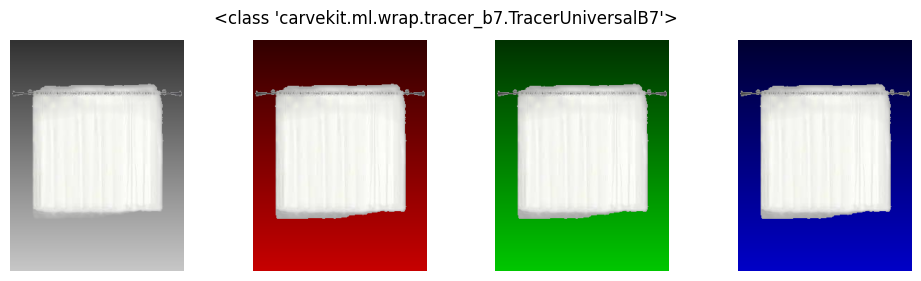

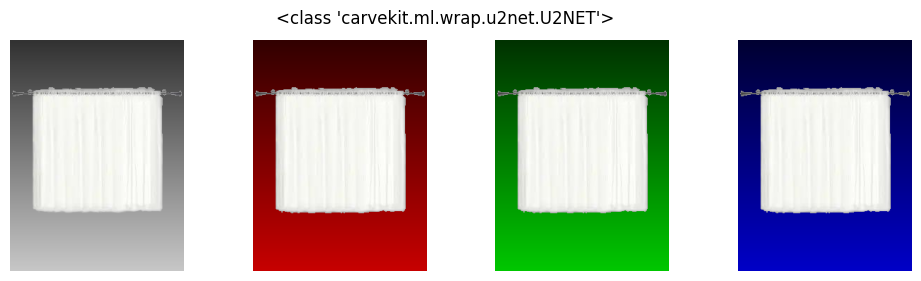

In [8]:
image_path = "./sirius_data/473.jpg"  # 60 473 4 6

for interface in interfaces:
    images_without_background = interface([image_path])
    cat_wo_bg = images_without_background[0]
    np_cat_wo_bg = np.array(cat_wo_bg)

    mask_bin = (np_cat_wo_bg[:, :, 3] > 0).astype(np.uint8)[..., None]
    image = np_cat_wo_bg[:, :, :3]

    final_images = []
    for color_choice in ("gray", "red", "green", "blue"):
        background = create_gradient_background(
            image.shape[:2],
            color=color_choice,
            start_intensity=50,
            end_intensity=200,
            orientation="vertical",
        )
        final_image = apply_background(image, mask_bin, background)
        final_images.append(final_image)
    display_images_in_row(final_images, title=interface.u2net.__class__)

In [9]:
output_directory = "./output_data_Tracer-B7"
os.makedirs(output_directory, exist_ok=True)
for image_path in image_paths:
    images_without_background = interfaces[0]([image_path])
    cat_wo_bg = images_without_background[0]
    cat_wo_bg.save(
        image_path.replace(data_directory, output_directory).replace("jpg", "png")
    )

# u2netp vs u2net vs sam vs birefnet-general vs isnet-general-use vs birefnet-massive vs birefnet-hrsod

In [10]:
models = [
    "u2netp",
    "u2net",
    "sam",
    "birefnet-general",
    "isnet-general-use",
    "birefnet-massive",
    "birefnet-hrsod",
]

In [11]:
sam_prompt = [{"type": "point", "label": 1, "data": [0.5, 0.5]}]
execution_times = []

providers = ["CUDAExecutionProvider"]

for model in models:
    session = new_session(model_name=model, providers=providers)

    output_folder = f"./output_data_{model}"
    os.makedirs(output_folder, exist_ok=True)

    start_time = time.time()
    for input_path in glob.glob("./sirius_data/*.jpg"):
        output_path = os.path.join(output_folder, os.path.basename(input_path))

        with open(input_path, "rb") as i:
            input_image = i.read()
            if model == "sam":
                output = remove(input_image, session=session, sam_prompt=sam_prompt)
            else:
                output = remove(input_image, session=session)

            output_image = cv2.imdecode(
                np.frombuffer(output, np.uint8), cv2.IMREAD_UNCHANGED
            )
            gradient_bg = create_gradient_background(
                output_image.shape[:2],
                color="gray",
                start_intensity=50,
                end_intensity=200,
                orientation="vertical",
            )
            mask = np.where(output_image[..., 3] > 0, 1, 0).astype(np.uint8)
            final_image = apply_background(
                output_image[..., :3], mask[..., None], gradient_bg
            )
            cv2.imwrite(output_path, final_image)

    end_time = time.time()
    execution_time = end_time - start_time
    execution_times.append({"Model": model, "Execution Time (seconds)": execution_time})
    print(f"Обработка {model} завершена. Время выполнения: {execution_time:.2f} секунд")

execution_df = pd.DataFrame(execution_times)
execution_df.to_csv("execution_times.csv", index=False)


Обработка u2netp завершена. Время выполнения: 12.41 секунд
Обработка u2net завершена. Время выполнения: 19.26 секунд
*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:490 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['CUDAExecutionProvider', 'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************


/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:75: UserWarning: Duplicate provider 'CUDAExecutionProvider' encountered, ignoring.
  warnings.warn(f"Duplicate provider '{name}' encountered, ignoring.")
2024-09-29 17:32:23.493680966 [E:onnxruntime:Default, provider_bridge_ort.cc:1978 TryGetProviderInfo_TensorRT] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_tensorrt.so with error: libnvinfer.so.10: cannot open shared object file: No such file or directory

2024-09-29 17:32:23.942155568 [E:onnxruntime:Default, provider_bridge_ort.cc:1978 TryGetProviderInfo_TensorRT] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonn

*************** EP Error ***************
EP Error /onnxruntime_src/onnxruntime/python/onnxruntime_pybind_state.cc:490 void onnxruntime::python::RegisterTensorRTPluginsAsCustomOps(PySessionOptions&, const onnxruntime::ProviderOptions&) Please install TensorRT libraries as mentioned in the GPU requirements page, make sure they're in the PATH or LD_LIBRARY_PATH, and that your GPU is supported.
 when using ['CUDAExecutionProvider', 'TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Falling back to ['CUDAExecutionProvider', 'CPUExecutionProvider'] and retrying.
****************************************
Обработка sam завершена. Время выполнения: 114.81 секунд


/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/rembg/sessions/birefnet_general.py:18: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-mat))


Обработка birefnet-general завершена. Время выполнения: 401.90 секунд
Обработка isnet-general-use завершена. Время выполнения: 48.17 секунд
Обработка birefnet-massive завершена. Время выполнения: 402.00 секунд
Обработка birefnet-hrsod завершена. Время выполнения: 408.41 секунд


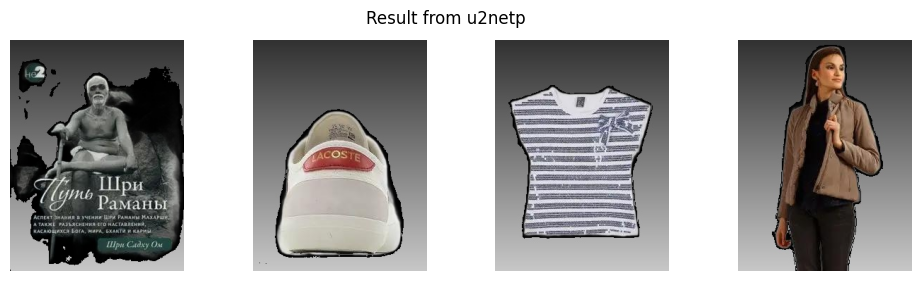

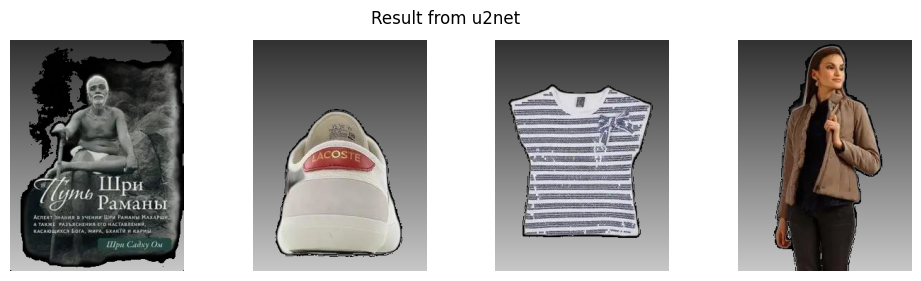

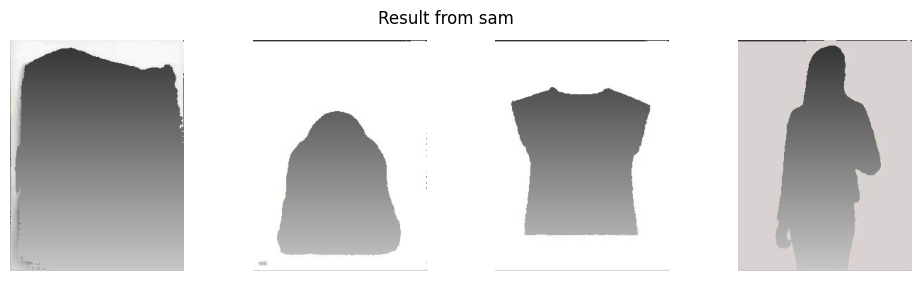

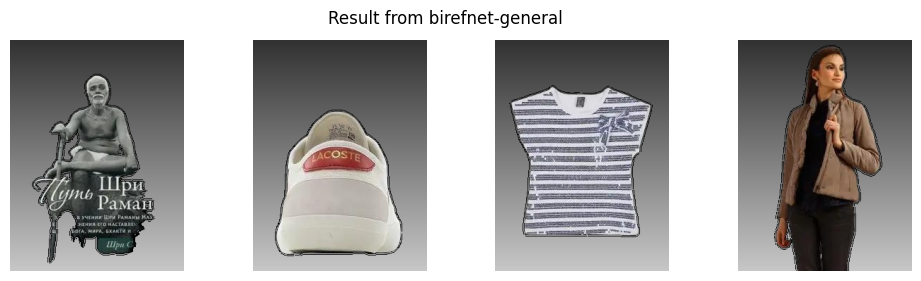

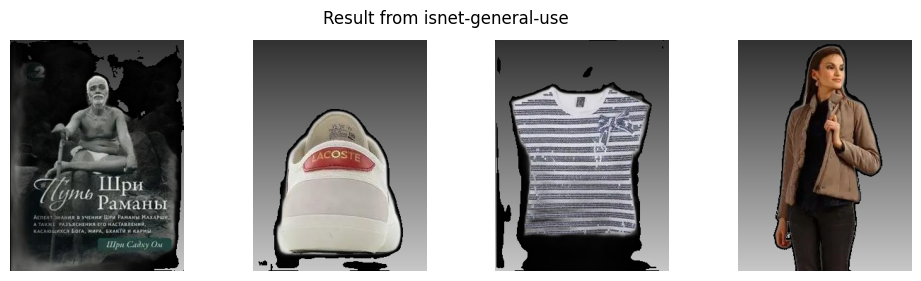

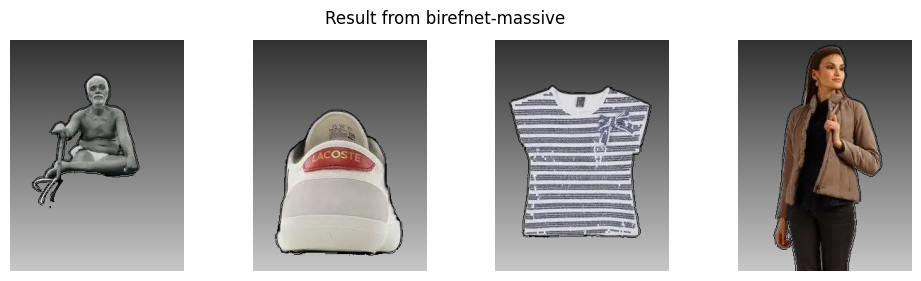

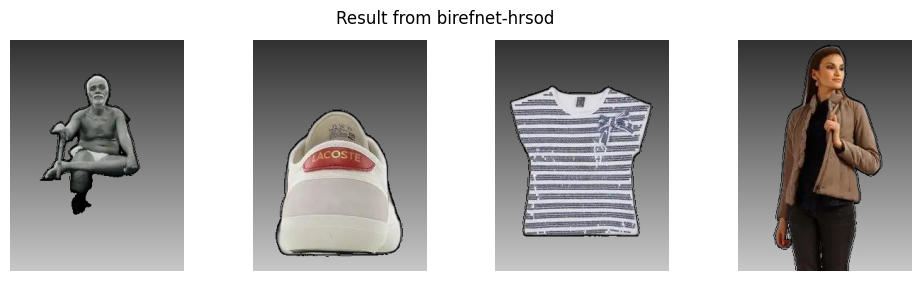

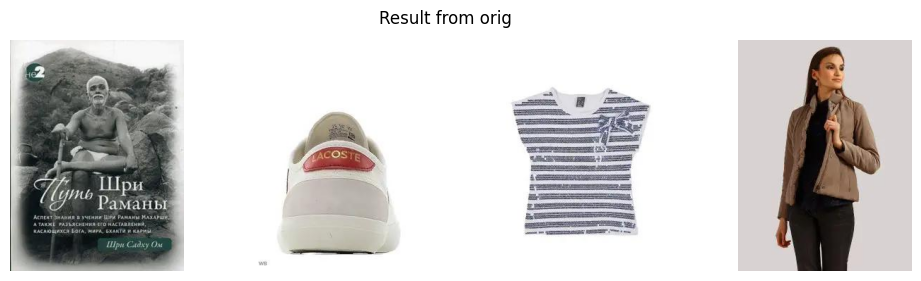

In [12]:
desired_numbers = np.random.randint(0, 499, 4)
desired_numbers = list(map(str, desired_numbers))

models.append("orig")

print()
for model in models:
    if model == "orig":
        output_folder = "./sirius_data"
    else:
        output_folder = f"./output_data_{model}"
    all_output_image_paths = glob.glob(os.path.join(output_folder, "*.jpg"))

    output_image_paths = [
        path
        for path in all_output_image_paths
        if any(num in os.path.basename(path) for num in desired_numbers)
    ]

    output_image_paths = output_image_paths[:4]
    output_images = []
    title = f"Result from {model}"

    for output_path in output_image_paths:
        output_image = cv2.imread(output_path)
        output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        output_images.append(output_image)

    display_images_in_row(
        output_images,
        title,
    )


## Conclusion

**birefnet-general** - best in accuracy, but lasts longer than others

# Creating descriptions

In [13]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
)


def generate_description(image_path: str) -> str:
    """
    Создает описание картинки.

    Параметры:
    image_path (str): путь до картинки.

    Возвращает:
    str: оисание.
    """
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs)
    description = processor.decode(out[0], skip_special_tokens=True)
    return description


def process_images_in_directory(directory_path: str, descriptions_dir: str) -> None:
    """
    Сохраняет описание всех изображений в директории в новую директорию,
    с теми же названиями файлов но c расширениеv txt.

    Параметры:
    directory_path (str): путь до директории с картинками.
    descriptions_dir (str):путь до новой директории с описаниями.
    """
    os.makedirs(descriptions_dir, exist_ok=True)

    for filename in tqdm(os.listdir(directory_path)):
        if filename.lower().endswith((".jpg", ".png", ".jpeg")):
            image_path = os.path.join(directory_path, filename)
            description = generate_description(image_path)

            txt_filename = os.path.splitext(filename)[0] + ".txt"
            txt_path = os.path.join(descriptions_dir, txt_filename)

            with open(txt_path, "w") as file:
                file.write(description)


directory = "./output_data_birefnet-general"
descriptions_dir = "./descriptions_birefnet-general"
process_images_in_directory(directory, descriptions_dir)


/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
  0%|          | 0/470 [00:00<?, ?it/s]/home/sergey/Projects/sirius_2024/.sirius/lib/python3.10/site-packages/transformers/generation/utils.py:1220: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  3%|▎         | 15/470 [00:12<05:55,  1.28it/s]

100%|██████████| 470/470 [06:34<00:00,  1.19it/s]
